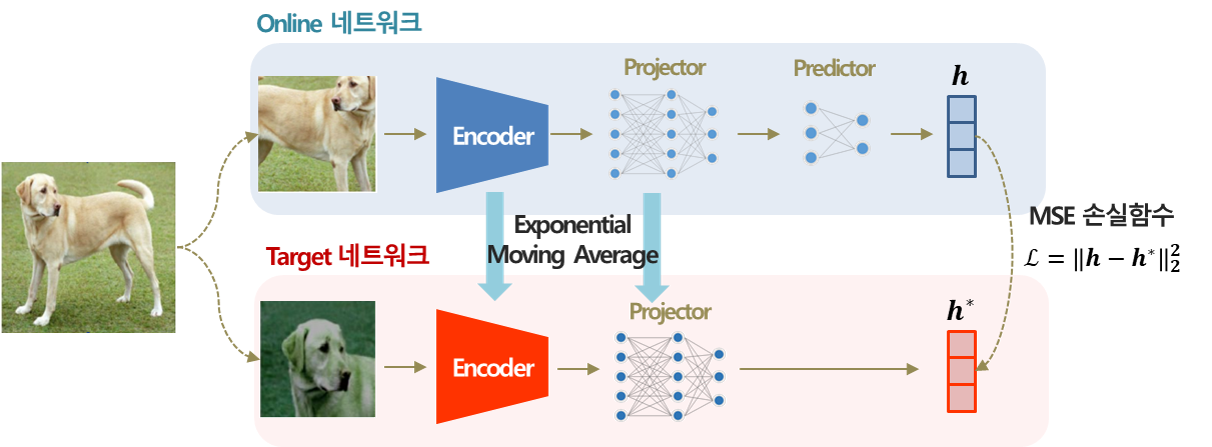

In [103]:
from IPython.display import Image
Image('./byol.png')

# 필요한 패키지 불러오기

In [104]:
import os
import numpy as np

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

from torch.utils.data import Dataset
from torchvision.transforms import transforms
from torchvision import transforms, datasets

import warnings
warnings.filterwarnings(action='ignore')

# 학습에 필요한 하이퍼파라미터 정의

In [105]:
ARCHITECTURE = 'resnet18'
MLP_HIDDEN_SIZE = 512
PROJECTION_SIZE = 128
NUM_WORKER = 0
EPOCHS = 5
BATCH_SIZE = 256
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-4
SEED = 123
NUM_CLASS = 10
LOG_EVERY_N_STEPS = 20
MOMENTUM = 0.996
GPU_INDEX = 0
DEVICE = 'cuda'

# CIFAR10 Dataset 정의

In [106]:
class CIFAR10Dataset(Dataset):
    def __init__(self, 
                 data_dir: str = './data',
                 mode: str = 'train'):
        
        self.data_dir = data_dir
        self.mode = mode
        
        # 저장 경로 폴더 없을 때 만들기
        os.makedirs(data_dir, exist_ok=True)
    
    @staticmethod
    def get_transform(size: int = None,
                      s: int = 1):
        """
        Return a set of data augmentation transformations 
        as described in the SimCLR paper.
        """
        
        normalize = transforms.Normalize(
            mean=(0.4914, 0.4822, 0.4465),
            std=(0.2023, 0.1994, 0.2010))
        color_jitter = transforms.ColorJitter(0.8 * s, 
                                              0.8 * s,
                                              0.8 * s,
                                              0.2 * s)
        data_transforms = transforms.Compose([
            transforms.RandomResizedCrop(size=size),
            transforms.RandomHorizontalFlip(),
            transforms.RandomApply([color_jitter], p=0.8),
            transforms.RandomGrayscale(p=0.2),
            GaussianBlur(kernel_size=int(0.1 * size)),
            transforms.ToTensor(),
            normalize,
        ])
        
        return data_transforms
    
    # For BYOL
    def get_pretrain_dataset(self):        
        # BYOL, 지도 학습에 사용되는 학습 데이터
        
        if self.mode == 'train':
            train_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=MultiViewGenerator(
                                                 base_transforms=self.get_transform(size=32)),
                                             download=True)
            
            return train_dataset
        
        else:
            raise NotImplementedError()
    
    # For Supervised Setting (Transfer Learning)
    def get_dataset(self):        
        # BYOL, 지도 학습에 사용되는 학습 데이터
        
        if self.mode == 'train':
            train_dataset = datasets.CIFAR10(self.data_dir,
                                             train=True,
                                             transform=transforms.ToTensor(),
                                             download=True)
            
            return train_dataset
        
        elif self.mode == 'test':
            # 지도 학습 테스트에 사용되는 테스트 데이터
            test_dataset = datasets.CIFAR10(self.data_dir,
                                            train=False,
                                            transform=transforms.ToTensor(),
                                            download=False)
            
            return test_dataset
        
        else:
            raise NotImplementedError()
            

class GaussianBlur(object):
    """
    blur a single image on CPU
    """
    def __init__(self, kernel_size: int = None):
        radias = kernel_size // 2
        kernel_size = radias * 2 + 1
        self.blur_h = nn.Conv2d(in_channels=3,
                                out_channels=3,
                                kernel_size=(kernel_size, 1),
                                stride=1,
                                padding=0, 
                                bias=False,
                                groups=3)
        self.blur_v = nn.Conv2d(in_channels=3,
                                out_channels=3,
                                kernel_size=(1, kernel_size),
                                stride=1,
                                padding=0, 
                                bias=False,
                                groups=3)
        self.k = kernel_size
        self.r = radias
        
        self.blur = nn.Sequential(
            nn.ReflectionPad2d(radias),
            self.blur_h,
            self.blur_v
        )
        
        self.pil_to_tensor = transforms.ToTensor()
        self.tensor_to_pil = transforms.ToPILImage()
    
    def __call__(self, img):
        img = self.pil_to_tensor(img).unsqueeze(0)
        
        sigma = np.random.uniform(0.1, 2.0)
        x = np.arange(-self.r, self.r + 1)
        x = np.exp(-np.power(x, 2) / (2 * sigma * sigma))
        x = x / x.sum()
        x = torch.from_numpy(x).view(1, -1).repeat(3, 1)
        
        self.blur_h.weight.data.copy_(x.view(3, 1, self.k, 1))
        self.blur_v.weight.data.copy_(x.view(3, 1, 1, self.k))
    
        with torch.no_grad():
            img = self.blur(img)
            img = img.squeeze()
        
        img = self.tensor_to_pil(img)
        
        return img
    
    
class MultiViewGenerator(object):
    """
    Take two random crops of one image as the query and key.
    """
    
    def __init__(self, base_transforms):
        self.transforms = base_transforms
    
    def __call__(self, x):
        output1 = self.transforms(x)
        output2 = self.transforms(x)
        
        output = [output1, output2]
#         output = [transform(x) for transform in self.transforms]
        
        return output

# 학습 네트워크 정의

In [107]:
class ResNet(nn.Module):
    def __init__(self, base_model: str = None):
        super(ResNet, self).__init__()
        
        self.resnet_dict = {
            'resnet18': models.resnet18(pretrained=False),
            'resnet50': models.resnet50(pretrained=False)
        }
        
        resnet = self.get_basemodel(base_model)
        
        # Define CNN encoder
        self.encoder = nn.Sequential(
            *list(resnet.children())[:-1])
        
        # Define MLP Projection
        self.projection = MLPHead(in_channels=resnet.fc.in_features,
                                  mlp_hidden_size=MLP_HIDDEN_SIZE,
                                  projection_size=PROJECTION_SIZE)
    
    def forward(self, x: torch.Tensor):
        h = self.encoder(x)
        h = h.view(h.shape[0], h.shape[1])
        
        return self.projection(h)
    
    def get_basemodel(self, model_name: str = None):
 
        model = self.resnet_dict[model_name]

        return model
    

class MLPHead(nn.Module):
    def __init__(self, 
                 in_channels: int,
                 mlp_hidden_size: int,
                 projection_size):
        super(MLPHead, self).__init__()
        
        self.mlp = nn.Sequential(
            nn.Linear(in_channels, mlp_hidden_size), 
            nn.BatchNorm1d(mlp_hidden_size),
            nn.ReLU(inplace=True),
            nn.Linear(mlp_hidden_size, projection_size)
        )
    
    def forward(self, x):
        
        return self.mlp(x)

# 평가 지표 및 BYOL 학습 정의

In [108]:
def accuracy(output: torch.FloatTensor, 
             target: torch.LongTensor, 
             topk: tuple = (1, )):
    """
    Computes the accuracy over the k top predictions
    for the specified values of k.
    """
    
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)
        
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        
        return res
    

class BYOL(object):
    def __init__(self, **kwargs):
        self.online_network = kwargs['model'].to(DEVICE)
        self.target_network = kwargs['model'].to(DEVICE)
        
        # Only Online Network
        self.predictor = kwargs['predictor'].to(DEVICE)
        self.optimizer = kwargs['optimizer']
        
    @torch.no_grad()
    def update_target_network_parameters(self):
        """
        Momentum Update of the Target Encoder
        """
        for param_q, param_k in zip(self.online_network.parameters(), self.target_network.parameters()):
            param_k.data = param_k.data * MOMENTUM + param_q.data * (1. - MOMENTUM)
            
    @staticmethod
    def byolloss(x: torch.FloatTensor, y: torch.FloatTensor):
        x = F.normalize(x, dim=1)
        y = F.normalize(y, dim=1)
        
        return 2 - 2 * (x * y).sum(dim=-1)
    
    def initialize_target_network(self):
        """
        Init Momentum Network as Target Encoder
        """
        for param_q, param_k in zip(self.online_network.parameters(), self.target_network.parameters()):
            param_k.data.copy_(param_q.data)  # Initialize
            param_k.requires_grad = False  # Not Update by Gradient
            
    def update(self, 
               batch_view_1: torch.FloatTensor, 
               batch_view_2: torch.FloatTensor):
        
        # Compute Online Feature
        predictions_from_view_1 = self.predictor(self.online_network(batch_view_1))
        predictions_from_view_2 = self.predictor(self.online_network(batch_view_2))
        
        # Compute Target Feature
        with torch.no_grad():
            targets_to_view_2 = self.target_network(batch_view_1)
            targets_to_view_1 = self.target_network(batch_view_2)
        
        loss = self.byolloss(predictions_from_view_1, targets_to_view_1)
        loss += self.byolloss(predictions_from_view_2, targets_to_view_2)
        
        return loss.mean()        
            
    def train(self, train_loader):
        
        n_iter = 0
        
        # Initialize Target Network
        self.initialize_target_network()
        
        for epoch in range(EPOCHS):
        
            train_loss = 0
            for (batch_view_1, batch_view_2), _ in tqdm(train_loader):
                batch_view_1 = batch_view_1.to(DEVICE)
                batch_view_2 = batch_view_2.to(DEVICE)
                
                loss = self.update(batch_view_1=batch_view_1, 
                                   batch_view_2=batch_view_2)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Update Target Encoder
                self.update_target_network_parameters()
                
                train_loss += loss
                
                if n_iter % LOG_EVERY_N_STEPS == 0:
                    print(f'Loss: {loss} \n')
                
                n_iter += 1
            
            train_loss /= (len(train_loader))
            
            print('=' * 30)
            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n')
            
        return self.online_network               

# BYOL 코드 실행

In [109]:
def main():
    
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    # Define Dataset, Dataloader
    dataset = CIFAR10Dataset(mode='train')
    
    train_dataset = dataset.get_pretrain_dataset()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKER,
        drop_last=True)
    
    # Define Model, predictor, optimizer
    model = ResNet(
        base_model=ARCHITECTURE)
    
    predictor = MLPHead(
        in_channels=PROJECTION_SIZE,
        mlp_hidden_size=PROJECTION_SIZE,
        projection_size=PROJECTION_SIZE)
    
    # Optimizing Encoder, predictor
    optim_params = list(model.parameters()) + list(predictor.parameters())
    optimizer = torch.optim.Adam(
        optim_params, 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY)

    with torch.cuda.device(GPU_INDEX):
        byol = BYOL(
            model=model,
            predictor=predictor,
            optimizer=optimizer)
        
        pretrained_model = byol.train(train_loader=train_loader)
    
    return pretrained_model


if __name__ == '__main__':
    pretrained_model = main()

Files already downloaded and verified


  1%|▍                                                                                 | 1/195 [00:00<02:40,  1.21it/s]

Loss: 3.8485615253448486 



 11%|████████▋                                                                        | 21/195 [00:16<02:20,  1.24it/s]

Loss: 2.702914237976074 



 21%|█████████████████                                                                | 41/195 [00:32<02:03,  1.25it/s]

Loss: 2.2298660278320312 



 31%|█████████████████████████▎                                                       | 61/195 [00:49<01:48,  1.24it/s]

Loss: 2.026646614074707 



 42%|█████████████████████████████████▋                                               | 81/195 [01:05<01:35,  1.19it/s]

Loss: 1.952523112297058 



 52%|█████████████████████████████████████████▍                                      | 101/195 [01:21<01:11,  1.31it/s]

Loss: 1.9006035327911377 



 62%|█████████████████████████████████████████████████▋                              | 121/195 [01:36<00:56,  1.31it/s]

Loss: 1.8720438480377197 



 72%|█████████████████████████████████████████████████████████▊                      | 141/195 [01:52<00:42,  1.27it/s]

Loss: 1.8402836322784424 



 83%|██████████████████████████████████████████████████████████████████              | 161/195 [02:08<00:28,  1.21it/s]

Loss: 1.8116546869277954 



 93%|██████████████████████████████████████████████████████████████████████████▎     | 181/195 [02:25<00:11,  1.25it/s]

Loss: 1.807166337966919 



  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 1 
Loss: 2.0979044437408447 



  3%|██▌                                                                               | 6/195 [00:04<02:22,  1.32it/s]

Loss: 1.7918776273727417 



 13%|██████████▊                                                                      | 26/195 [00:19<02:09,  1.31it/s]

Loss: 1.7830582857131958 



 24%|███████████████████                                                              | 46/195 [00:34<01:54,  1.31it/s]

Loss: 1.7611644268035889 



 34%|███████████████████████████▍                                                     | 66/195 [00:50<01:37,  1.32it/s]

Loss: 1.771632194519043 



 44%|███████████████████████████████████▋                                             | 86/195 [01:06<01:29,  1.22it/s]

Loss: 1.7709788084030151 



 54%|███████████████████████████████████████████▍                                    | 106/195 [01:22<01:11,  1.25it/s]

Loss: 1.7492810487747192 



 65%|███████████████████████████████████████████████████▋                            | 126/195 [01:38<00:54,  1.27it/s]

Loss: 1.7514102458953857 



 75%|███████████████████████████████████████████████████████████▉                    | 146/195 [01:53<00:38,  1.26it/s]

Loss: 1.762674331665039 



 85%|████████████████████████████████████████████████████████████████████            | 166/195 [02:09<00:21,  1.33it/s]

Loss: 1.7614870071411133 



 95%|████████████████████████████████████████████████████████████████████████████▎   | 186/195 [02:24<00:06,  1.30it/s]

Loss: 1.750111699104309 



  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 2 
Loss: 1.7640094757080078 



  6%|████▌                                                                            | 11/195 [00:08<02:18,  1.33it/s]

Loss: 1.7314170598983765 



 16%|████████████▉                                                                    | 31/195 [00:23<02:06,  1.30it/s]

Loss: 1.7363739013671875 



 26%|█████████████████████▏                                                           | 51/195 [00:39<01:56,  1.24it/s]

Loss: 1.7469606399536133 



 36%|█████████████████████████████▍                                                   | 71/195 [00:55<01:38,  1.26it/s]

Loss: 1.720824956893921 



 47%|█████████████████████████████████████▊                                           | 91/195 [01:11<01:24,  1.23it/s]

Loss: 1.735236406326294 



 57%|█████████████████████████████████████████████▌                                  | 111/195 [01:27<01:02,  1.34it/s]

Loss: 1.7408990859985352 



 67%|█████████████████████████████████████████████████████▋                          | 131/195 [01:42<00:48,  1.31it/s]

Loss: 1.7595176696777344 



 77%|█████████████████████████████████████████████████████████████▉                  | 151/195 [01:58<00:33,  1.33it/s]

Loss: 1.7408688068389893 



 88%|██████████████████████████████████████████████████████████████████████▏         | 171/195 [02:13<00:18,  1.30it/s]

Loss: 1.7424050569534302 



 98%|██████████████████████████████████████████████████████████████████████████████▎ | 191/195 [02:28<00:03,  1.32it/s]

Loss: 1.7223522663116455 



  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 3 
Loss: 1.739526391029358 



  8%|██████▋                                                                          | 16/195 [00:12<02:25,  1.23it/s]

Loss: 1.7400414943695068 



 18%|██████████████▉                                                                  | 36/195 [00:28<02:10,  1.22it/s]

Loss: 1.745933175086975 



 29%|███████████████████████▎                                                         | 56/195 [00:44<01:52,  1.23it/s]

Loss: 1.7426793575286865 



 39%|███████████████████████████████▌                                                 | 76/195 [01:00<01:30,  1.31it/s]

Loss: 1.7262303829193115 



 49%|███████████████████████████████████████▉                                         | 96/195 [01:15<01:14,  1.32it/s]

Loss: 1.724908709526062 



 59%|███████████████████████████████████████████████▌                                | 116/195 [01:30<01:01,  1.29it/s]

Loss: 1.7350044250488281 



 70%|███████████████████████████████████████████████████████▊                        | 136/195 [01:45<00:44,  1.32it/s]

Loss: 1.7338372468948364 



 80%|████████████████████████████████████████████████████████████████                | 156/195 [02:01<00:30,  1.28it/s]

Loss: 1.737032413482666 



 90%|████████████████████████████████████████████████████████████████████████▏       | 176/195 [02:17<00:15,  1.25it/s]

Loss: 1.7342338562011719 



  0%|                                                                                          | 0/195 [00:00<?, ?it/s]

Epoch: 4 
Loss: 1.7306081056594849 



  1%|▍                                                                                 | 1/195 [00:00<02:06,  1.53it/s]

Loss: 1.7278250455856323 



 11%|████████▋                                                                        | 21/195 [00:14<01:58,  1.47it/s]

Loss: 1.722091555595398 



 21%|█████████████████                                                                | 41/195 [00:27<01:37,  1.57it/s]

Loss: 1.7126774787902832 



 31%|█████████████████████████▎                                                       | 61/195 [00:43<01:44,  1.29it/s]

Loss: 1.726909875869751 



 42%|█████████████████████████████████▋                                               | 81/195 [00:58<01:27,  1.30it/s]

Loss: 1.7229690551757812 



 52%|█████████████████████████████████████████▍                                      | 101/195 [01:13<01:11,  1.31it/s]

Loss: 1.7308419942855835 



 62%|█████████████████████████████████████████████████▋                              | 121/195 [01:29<00:59,  1.25it/s]

Loss: 1.7291109561920166 



 72%|█████████████████████████████████████████████████████████▊                      | 141/195 [01:45<00:43,  1.25it/s]

Loss: 1.7259477376937866 



 83%|██████████████████████████████████████████████████████████████████              | 161/195 [02:01<00:27,  1.22it/s]

Loss: 1.7247874736785889 



 93%|██████████████████████████████████████████████████████████████████████████▎     | 181/195 [02:18<00:11,  1.27it/s]

Loss: 1.7216465473175049 



100%|████████████████████████████████████████████████████████████████████████████████| 195/195 [02:28<00:00,  1.31it/s]

Epoch: 5 
Loss: 1.7256866693496704 



# BYOL로 사전 학습한 인코더를 사용하여 지도 학습 수행

In [112]:
class Supervised(object):
    def __init__(self, **kwargs):
        self.encoder = kwargs['encoder'].to(DEVICE)
        self.classifier = kwargs['classifier'].to(DEVICE)
        self.optimizer = kwargs['optimizer']
        self.criterion = nn.CrossEntropyLoss().to(DEVICE)
        
    def train_test(self, train_loader, test_loader):
        
        for epoch in range(EPOCHS):
            
            # Train
            top1_train_acc, train_loss = 0, 0
            for i, (images, targets) in enumerate(train_loader):
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                
                # Freeze Encoder Parameters
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    
                logits = self.classifier(logits)
                loss = self.criterion(logits, targets)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                top1 = accuracy(logits, targets, topk=(1, ))
                top1_train_acc += top1[0]
                
                train_loss += loss
            
            top1_train_acc /= (i + 1)
            train_loss /= (i + 1)
            
            # Test
            top1_test_acc = 0
            top5_test_acc = 0
            for i, (images, targets) in enumerate(test_loader):
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                
                with torch.no_grad():
                    logits = self.encoder(images)
                    logits = logits.squeeze()
                    logits = self.classifier(logits)
                
                top1, top5 = accuracy(logits, targets, topk=(1, 5))
                top1_test_acc += top1[0]
                top5_test_acc += top5[0]
            
            top1_test_acc /= (i + 1)
            top5_test_acc /= (i + 1)

            print(f'Epoch: {epoch + 1} \n'
                  f'Loss: {train_loss} \n'
                  f'Top1 Train Accuracy: {top1_train_acc.item()} \n'
                  f'Top1 Test Accuracy: {top1_test_acc.item()} \n'
                  f'Top5 Test Accuracy: {top5_test_acc.item()} \n')
            
        return self.encoder, self.classifier

# 지도 학습 실행

In [113]:
def main():
    
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    
    # Define Dataset, Dataloader
    train_dataset = CIFAR10Dataset(mode='train')
    test_dataset = CIFAR10Dataset(mode='test')
    
    train_dataset = train_dataset.get_dataset()
    test_dataset = test_dataset.get_dataset()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKER,
        drop_last=False)
    
    test_loader = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKER,
        drop_last=False)
    
    # Define Model, optimizer, linear classifier
    encoder = pretrained_model.encoder
    
    classifier = nn.Linear(512, NUM_CLASS)
    
    optimizer = torch.optim.Adam(
        classifier.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=WEIGHT_DECAY)
    
    with torch.cuda.device(GPU_INDEX):
        supervised = Supervised(
            encoder=encoder,
            classifier=classifier,
            optimizer=optimizer)
        
        supervised_encoder, supervised_classifier = supervised.train_test(train_loader=train_loader,
                                                                          test_loader=test_loader)
    
    return supervised_encoder, supervised_classifier


if __name__ == '__main__':
    supervised_model = main()

Files already downloaded and verified
Epoch: 1 
Loss: 2.203186511993408 
Top1 Train Accuracy: 19.413663864135742 
Top1 Test Accuracy: 25.37109375 
Top5 Test Accuracy: 74.98046875 

Epoch: 2 
Loss: 2.010806083679199 
Top1 Train Accuracy: 27.319833755493164 
Top1 Test Accuracy: 29.052734375 
Top5 Test Accuracy: 78.671875 

Epoch: 3 
Loss: 1.950207233428955 
Top1 Train Accuracy: 29.933034896850586 
Top1 Test Accuracy: 30.3125 
Top5 Test Accuracy: 79.9609375 

Epoch: 4 
Loss: 1.9196476936340332 
Top1 Train Accuracy: 31.43255615234375 
Top1 Test Accuracy: 30.8984375 
Top5 Test Accuracy: 80.712890625 

Epoch: 5 
Loss: 1.900625228881836 
Top1 Train Accuracy: 32.2309455871582 
Top1 Test Accuracy: 31.6796875 
Top5 Test Accuracy: 81.26953125 

